## This notebook demonstrates typical usages of OSCAR
### Introduction

An "(energy) landscape" of a variational quantum algorithm (VQA) is the ensemble of objective function values over the parameter space, where each value is the expectation of measuring the problem Hamiltonian with the variational ansatz under the corresponding parameters. OSCAR exploits landscapes to provide VQA debugging featuers.

In OSCAR, the `oscar.Landscape` class uses a discretized grid over parameters in given ranges ([#Landscape](#landscape)), where the grid values are calculated by an `oscar.BaseExecutor` ([#Executor](#executor)). To speed up this grid generation process, OSCAR provides the option to approximate the grid values using only a small fraction of samples ([#Reconstruction](#reconstruction)). Additionally, OSCAR can interpolate the grid points to provide a continuous function approximating the landscape for instant optimization runs ([#Interpolation](#interpolation)). 

### Landscape

Define the landscape with parameter resolutions (granularity) and parameter bounds.
The order of the parameters corresponds to their order in the VQA ansatz definition. In the case of qiskit QAOA, the order is all betas and then all gammas.

In [ ]:
from oscar import Landscape
from math import pi

resolution = [64, 64]
bounds = [(-pi / 4, pi / 4), (-pi / 2, pi / 2)]
landscape = Landscape(resolution, bounds)

### Executor
#### Custom Executor

An executor can be easily constructed with a user-defined function that outputs the value of given input parameters.

In [ ]:
from __future__ import annotations
from collections.abc import Sequence
from oscar import CustomExecutor

def f(params: Sequence[float]) -> float:
    ...

custom_executor = CustomExecutor(f)

#### Qiskit Executor

OSCAR also provides an executor that works with Qiskit problem and VQA classes.
As an example, let's solve a 3-regular graph MaxCut problem with QAOA. First, define the problem of interest with `qiskit_optimization` (or `qiskit_finance`, `qiskit_nature`, or `docplex.mp` for more problems). These packages need to be manually installed.

In [ ]:
import networkx as nx
from qiskit_optimization.applications import Maxcut

n = 8
graph = nx.random_regular_graph(3, n)
problem = Maxcut(graph).to_quadratic_program()
H, offset = problem.to_ising() # construct the Hamiltonian

Define the desired Qiskit VQA.
OSCAR supports both the old `VQE` and `QAOA` that are being deprecated and the new `VQE`, `SamplingVQE`, and `QAOA` that use the `Estimator` and `Sampler` primitives.

In [ ]:
# New
from qiskit_aer.primitives import Sampler
from qiskit.algorithms.minimum_eigensolvers import QAOA as NewQAOA
from qiskit.algorithms.optimizers import COBYLA

algorithm = NewQAOA(Sampler(), COBYLA())

In [ ]:
# Old
from qiskit_aer import AerSimulator
from qiskit.algorithms import QAOA as OldQAOA
from qiskit.algorithms.optimizers import COBYLA

algorithm = OldQAOA(COBYLA(), quantum_instance=AerSimulator())

Define the executor responsible for computing the landscape data with the previously constructed VQA and Hamiltonian and generate the sampled points.

In [ ]:
from oscar import QiskitExecutor

qiskit_executor = QiskitExecutor(algorithm, H)

### Reconstruction

Sample a few points on the grid and get their value using our previously-defined executor.

In [ ]:
_ = landscape.sample_and_run(qiskit_executor, sampling_fraction = 1 / 16)

Reconstruct the full landscape with a desired `oscar.BaseReconstructor` and visualize the reconstructed landscape.

In [ ]:
from oscar import BPDNReconstructor, plot_2d_landscape

landscape.reconstruct(BPDNReconstructor(solver = None)) # choose and config a desired cvxpy solver
figure = plot_2d_landscape(landscape, which_landscape="reconstructed")

Run the true landscape and compare.

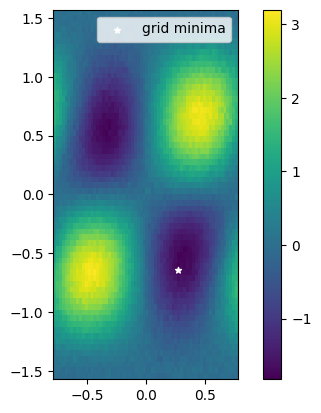

In [11]:
# may take some time
landscape.run_all(qiskit_executor)
figure = plot_2d_landscape(landscape, which_landscape="true")

### Interpolation
OSCAR can interpolate the grid points to get a continuous approximation of the landscape, which can in turn serve as an executor for optimizers and other purposes.

Total time: 0.03019261360168457
Optimal parameters reported:  [ 0.31166593 -0.52359878]
Optimal value reported:  -1.775390619926431
Number of evaluations:  100


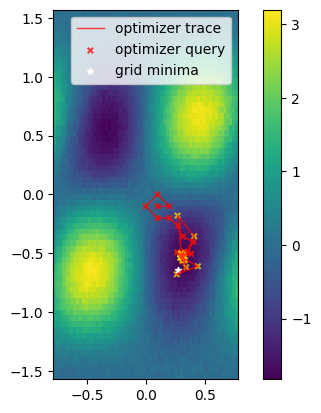

In [12]:
from oscar import ScikitQuantOptimizer, InterpolatedLandscapeExecutor

landscape.interpolate(method="slinear", fill_value=1)
itpl_executor = InterpolatedLandscapeExecutor(landscape)

def optimize_result(executor):
    trace, original_result = ScikitQuantOptimizer("bobyqa", budget=100).run(
        itpl_executor, initial_point=[0.1, -0.1], bounds=bounds
    )
    print(f"Total time: {sum(trace.time_trace)}")
    print("Optimal parameters reported: ", trace.optimal_params)
    print("Optimal value reported: ", trace.optimal_value)
    print("Number of evaluations: ", trace.num_fun_evals)
    plot_2d_landscape(landscape, trace)

optimize_result(itpl_executor)

Compare with the optimization where the values are calculated by actual circuit executions.

Total time: 0.029076814651489258
Optimal parameters reported:  [ 0.31166593 -0.52359878]
Optimal value reported:  -1.775390619926431
Number of evaluations:  100


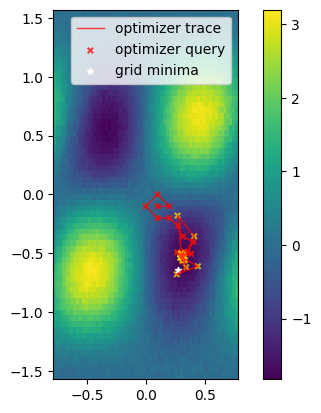

In [13]:
optimize_result(qiskit_executor)

We see that the results are very close, while the time for optimizing with the interpolated landscape is negligible compared to the actual optimization.

Landscapes can be easily saved for later retrieval.

In [14]:
import numpy as np

filename = f"../data/landscapes/p=1-{n=}-{bounds}-{resolution}.pckl"
landscape.save(filename)
landscape = np.load(filename, allow_pickle=True)